# Analyze and plot methods for hurricane forecast uncertainty
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.1.0
##### date: 14 December 2021

```
conda create --name env-hurr-tfp python=3.9
conda activate env-hurr-tfp
pip install tensorflow==2.7.0
pip install tensorflow-probability==0.15.0
pip install --upgrade numpy scipy pandas statsmodels matplotlib seaborn 
pip install --upgrade palettable progressbar2 tabulate icecream flake8
pip install --upgrade keras-tuner sklearn
pip install --upgrade jupyterlab black isort jupyterlab_code_formatter
pip install silence-tensorflow
pip install tqdm
```

Use the command
```python -m pip freeze > requirements.txt```
to make a pip installation list.

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shash
from build_data import build_hurricane_data
from build_model import build_shash_model, build_bnn_model
from custom_loss import compute_shash_NLL, compute_NLL
from custom_metrics import CustomMAE, InterquartileCapture, SignTest
from model_diagnostics import plot_history
from save_model_run import save_model_run
from sklearn import preprocessing
from tensorflow.keras import optimizers
from training_instrumentation import TrainingInstrumentation
from silence_tensorflow import silence_tensorflow
import tensorflow_probability as tfp
from keras.utils.layer_utils import count_params  
import prediction

from tqdm import tqdm

silence_tensorflow()
dpiFig = 400

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "15 December 2021"

# EXP_NAME_LIST = ("intensity0_AL72","intensity1_AL72")
# EXP_NAME_LIST = ("intensity2_EPCP48","intensity3_EPCP48")
# EXP_NAME_LIST = ("intensity4_EPCP72","intensity5_EPCP72")

EXP_NAME_LIST = ("intensity100_EPCP48","intensity101_EPCP48")
# EXP_NAME_LIST = ("intensity102_EPCP48","intensity103_EPCP48")


DATA_PATH = "data/"
MODEL_PATH = "saved_models/"

In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Load the models

In [4]:
for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)
    # pprint.pprint(settings, width=80)
    
    NETWORK_SEED_LIST = [settings["rng_seed"]]
    network_seed = NETWORK_SEED_LIST[0]
    tf.random.set_seed(network_seed)  # This sets the global random seed.    
    
    (x_train,
        onehot_train,
        x_val,
        onehot_val,
        data_summary,
        df,
    ) = build_hurricane_data(DATA_PATH, settings, verbose=0)    

    if settings["uncertainty_type"] == "bnn":       
        model_name_bnn = (
            exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
        pprint.pprint(model_name_bnn)
        
        model_bnn = build_bnn_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )
        model_bnn.load_weights(MODEL_PATH + model_name_bnn + "_weights.h5")

    elif settings["uncertainty_type"][:5] == "shash": 
        model_name_shash = (
            exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
        pprint.pprint(model_name_shash)
        
        model_shash = build_shash_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )
        model_shash.load_weights(MODEL_PATH + model_name_shash + "_weights.h5")
        
    


settings["train_condition"] is undefined
'intensity100_EPCP48_shash3_network_seed_999_rng_seed_999'
settings["train_condition"] is undefined
'intensity101_EPCP48_bnn_network_seed_999_rng_seed_999'


/Users/eabarnes/opt/anaconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/Users/eabarnes/opt/anaconda3/envs/env-hurr-tfp/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


## Make Model Predictions

In [5]:
runs = 5_000
shash_incs = np.arange(-160,161,1)
shash_cpd = np.zeros((np.shape(x_val)[0],len(shash_incs)))
shash_med = np.zeros((np.shape(x_val)[0],))
bnn_cpd = np.zeros((np.shape(x_val)[0],runs))
tf.random.set_seed(network_seed)

# loop through samples for shash calculation and get PDF for each sample
for j in tqdm(range(0,np.shape(shash_cpd)[0])):
    mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params( x_val[np.newaxis,j], model_shash )
    shash_cpd[j,:] = shash.prob(shash_incs, mu_pred, sigma_pred, gamma_pred, tau_pred)    
    shash_med[j]   = shash.median(mu_pred,sigma_pred,gamma_pred,tau_pred)
    
# loop through runs for bnn calculation    
for i in tqdm(range(0,runs)):
    bnn_cpd[:,i] = np.reshape(model_bnn.predict(x_val),np.shape(bnn_cpd)[0])
     

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:33<00:00, 23.39it/s]


## Plot Results

---sample 459 negative-log-likelihood being set to 10.0 due to log(0) issues


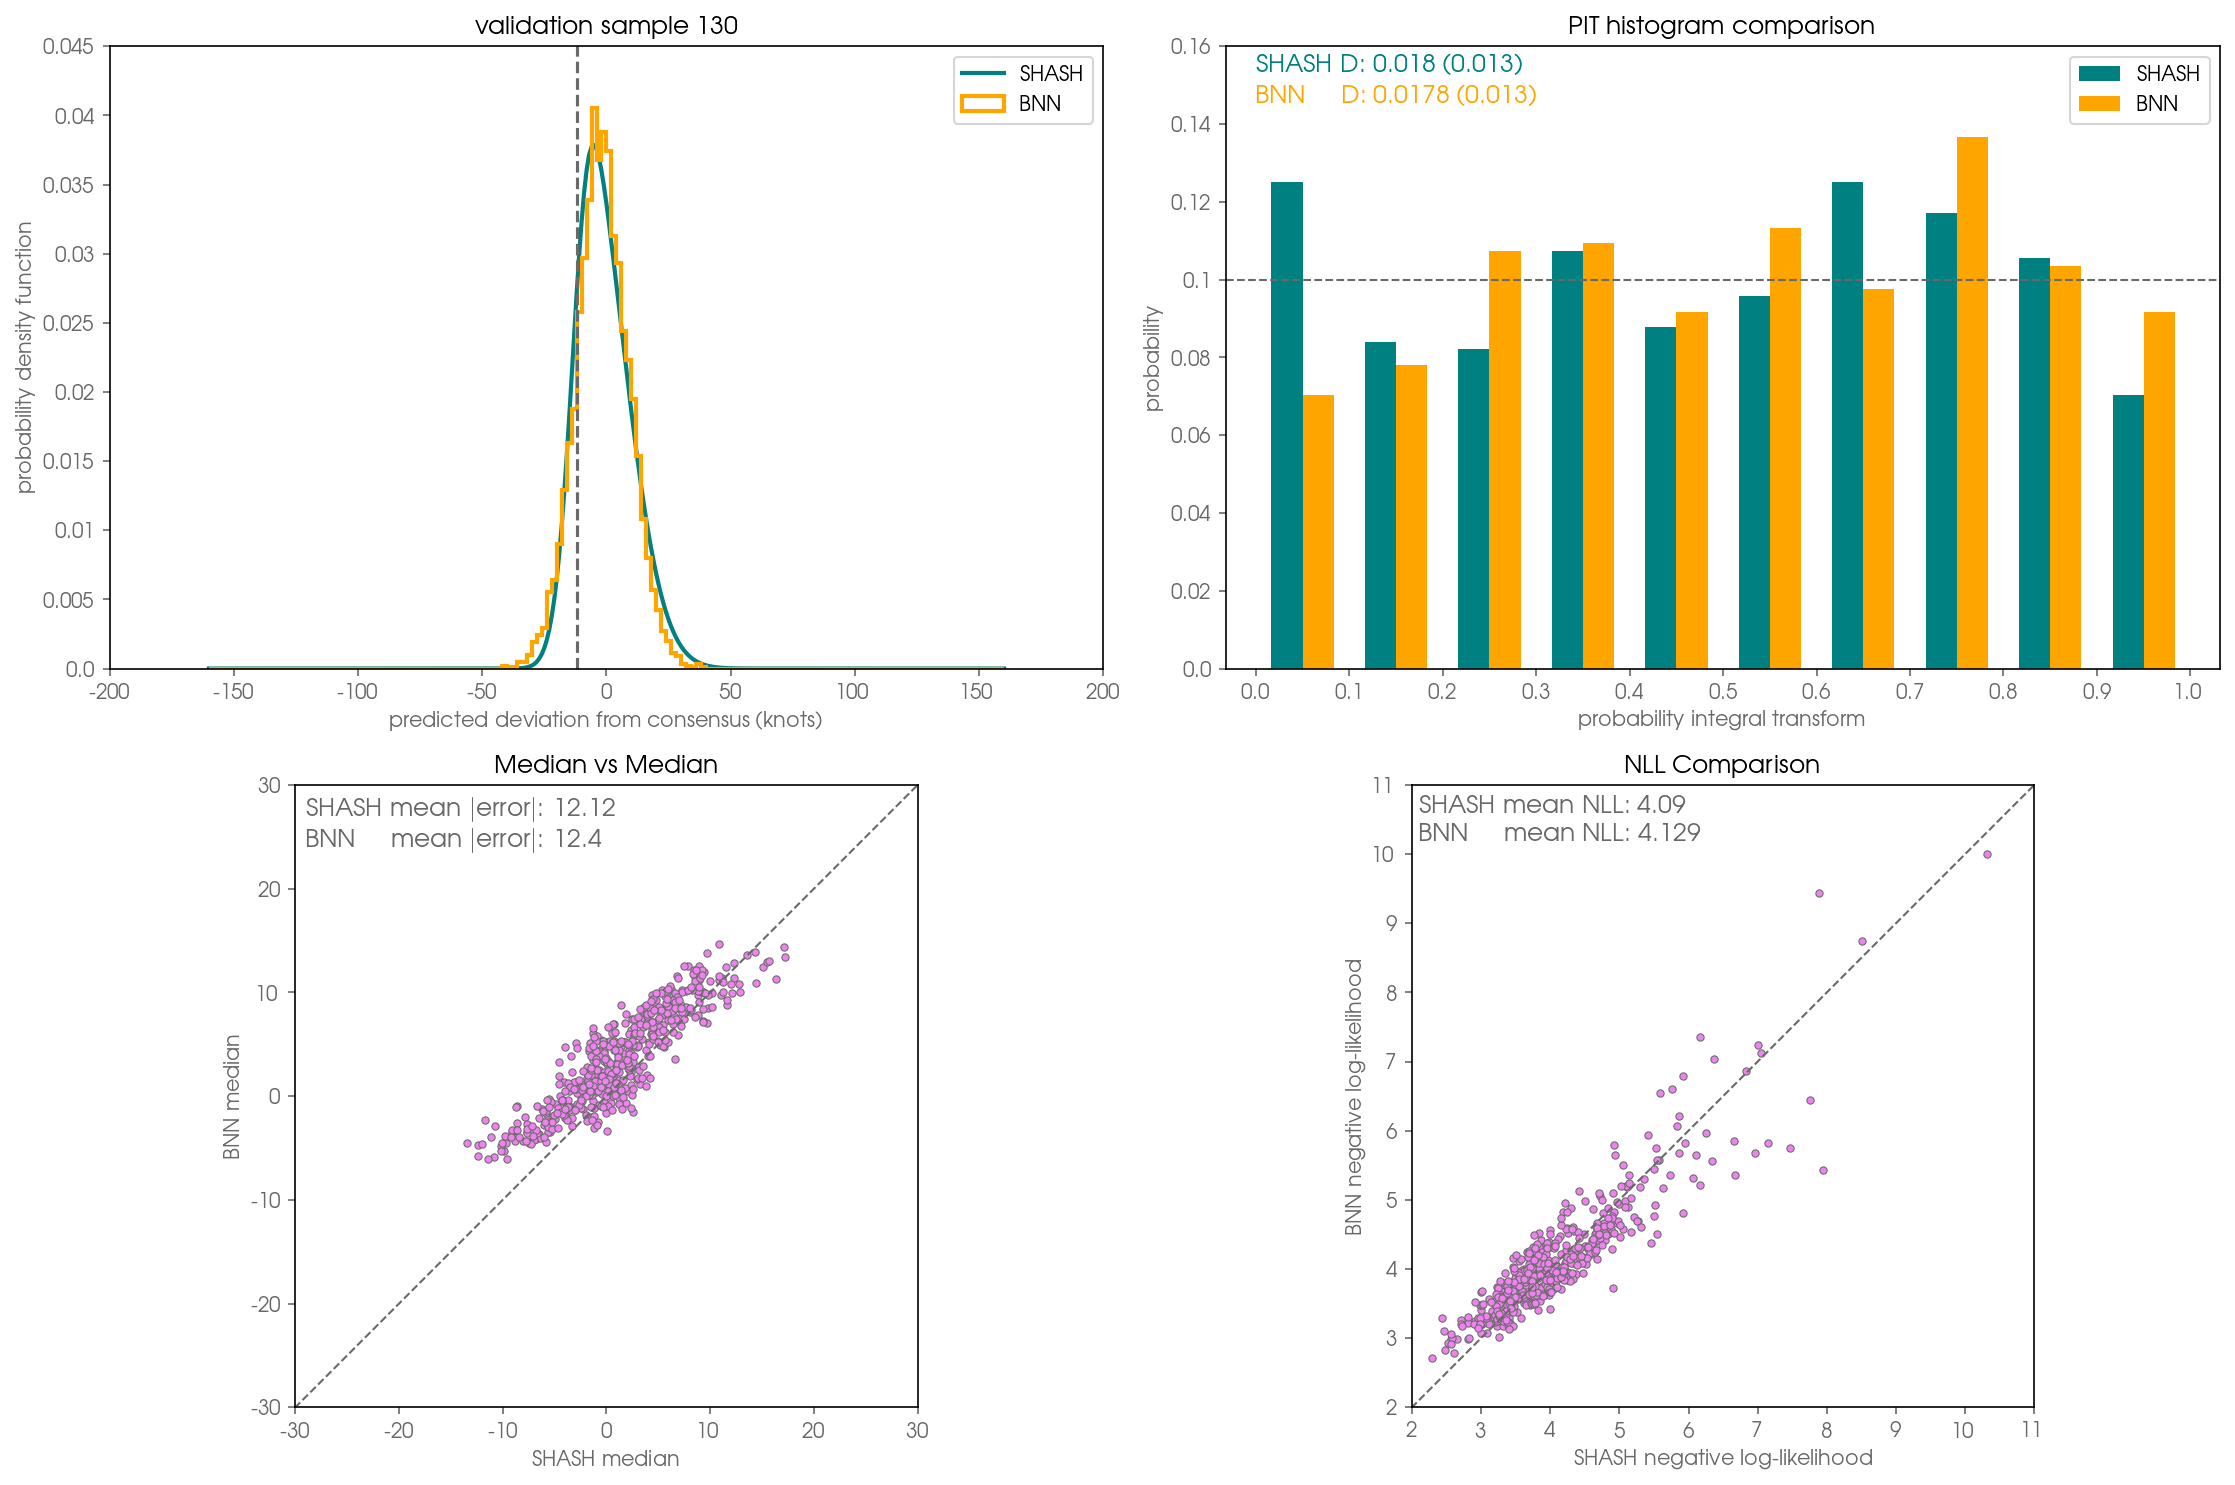

In [6]:
import analysis_plots
import imp
imp.reload(analysis_plots)

f, axs = plt.subplots(2, 2, figsize=(15,10))

# plot sample
ax = axs[0,0]
analysis_plots.plot_sample(ax, onehot_val, shash_incs, shash_cpd, bnn_cpd)

# plot PITS
ax = axs[0,1]
analysis_plots.plot_pits(ax, x_val, onehot_val, model_shash, shash_cpd, bnn_cpd)

# plot median vs median
ax = axs[1,0]
analysis_plots.plot_medians(ax, onehot_val, shash_cpd, bnn_cpd, shash_med)

# plot NLLs
ax = axs[1,1]
analysis_plots.plot_nlls(ax, x_val, onehot_val, model_shash, shash_cpd, bnn_cpd)

plt.tight_layout()

plt.savefig('figures/prediction_plots/comparisonsPanels_' + model_name_shash + '_' + model_name_bnn + '.png', dpi=dpiFig)    
plt.show()